In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy import stats
import os
import matplotlib.pyplot as plt
%matplotlib notebook

Load the data. Restructure with the collowing columns:

- bag_id
- label
- country
- total_eligible_instances
- total_instances
- num_instances
- How many positive labels per bag?

In [4]:
data_dir = f"{os.environ['MINERVA_HOME']}/data/premade_mil"

data = []
keep_cols = ["bag_id", "country", "label", "split", "total_eligible_instances", 
             "total_instances", "num_instances", "instance_scores"]
for file in os.listdir(data_dir):
    if not file.endswith(".jsonl"):
        continue
    print(f"Loading {file}")
    # Files are really big, chunk for usability
    for chunk in tqdm(pd.read_json(f"{data_dir}/{file}", lines=True, chunksize=1000), ncols=0):
        chunk["split"] = file.split(".")[0]
        chunk["country"] = chunk["bag_id"].map(lambda x: x.split("_")[-1])
        chunk["instance_scores"] = chunk["instances"].map(lambda x: [i['civil_unrest_score'] for i in x])
        data.append(chunk.loc[:, keep_cols])
df = pd.concat(data)

Loading train.jsonl


42it [04:18,  6.15s/it]


Loading val.jsonl


15it [01:12,  4.86s/it]


Loading test.jsonl


30it [02:43,  5.46s/it]


In [5]:
df

,bag_id,country,label,split,total_eligible_instances,total_instances,num_instances,instance_scores
0,2016_09_18_SLE,SLE,0,train,14,17,14,"[0.200971260666847, 0.09450465440750101, 0.073..."
1,2015_07_07_MWI,MWI,0,train,218,233,218,"[0.049337491393089, 0.21283537149429302, 0.438..."
2,2014_06_18_TZA,TZA,0,train,1100,1167,1100,"[0.22411993145942602, 0.303004503250122, 0.015..."
3,2015_08_02_CIV,CIV,0,train,196,223,196,"[0.366656959056854, 0.20087090134620603, 0.261..."
4,2015_07_22_MOZ,MOZ,0,train,108,117,108,"[0.43971386551856906, 0.360893338918685, 0.314..."
...,...,...,...,...,...,...,...,...
29960,2018_05_18_GHA,GHA,0,test,3715,4043,3715,"[0.21567252278327903, 0.30260562896728505, 0.1..."
29961,2018_10_25_BFA,BFA,0,test,20,20,20,"[0.089061275124549, 0.24281507730484003, 0.148..."
29962,2019_04_23_NGA,NGA,1,test,22059,24640,22059,"[0.197037115693092, 0.38013136386871305, 0.189..."
29963,2019_09_09_CAF,CAF,0,test,1,1,1,[0.33653730154037403]


## Q1: Basic data stats

A. How much original data is there?

B. How much data is left after cleaning?

C. What is this per-country?

<IPython.core.display.Javascript object>


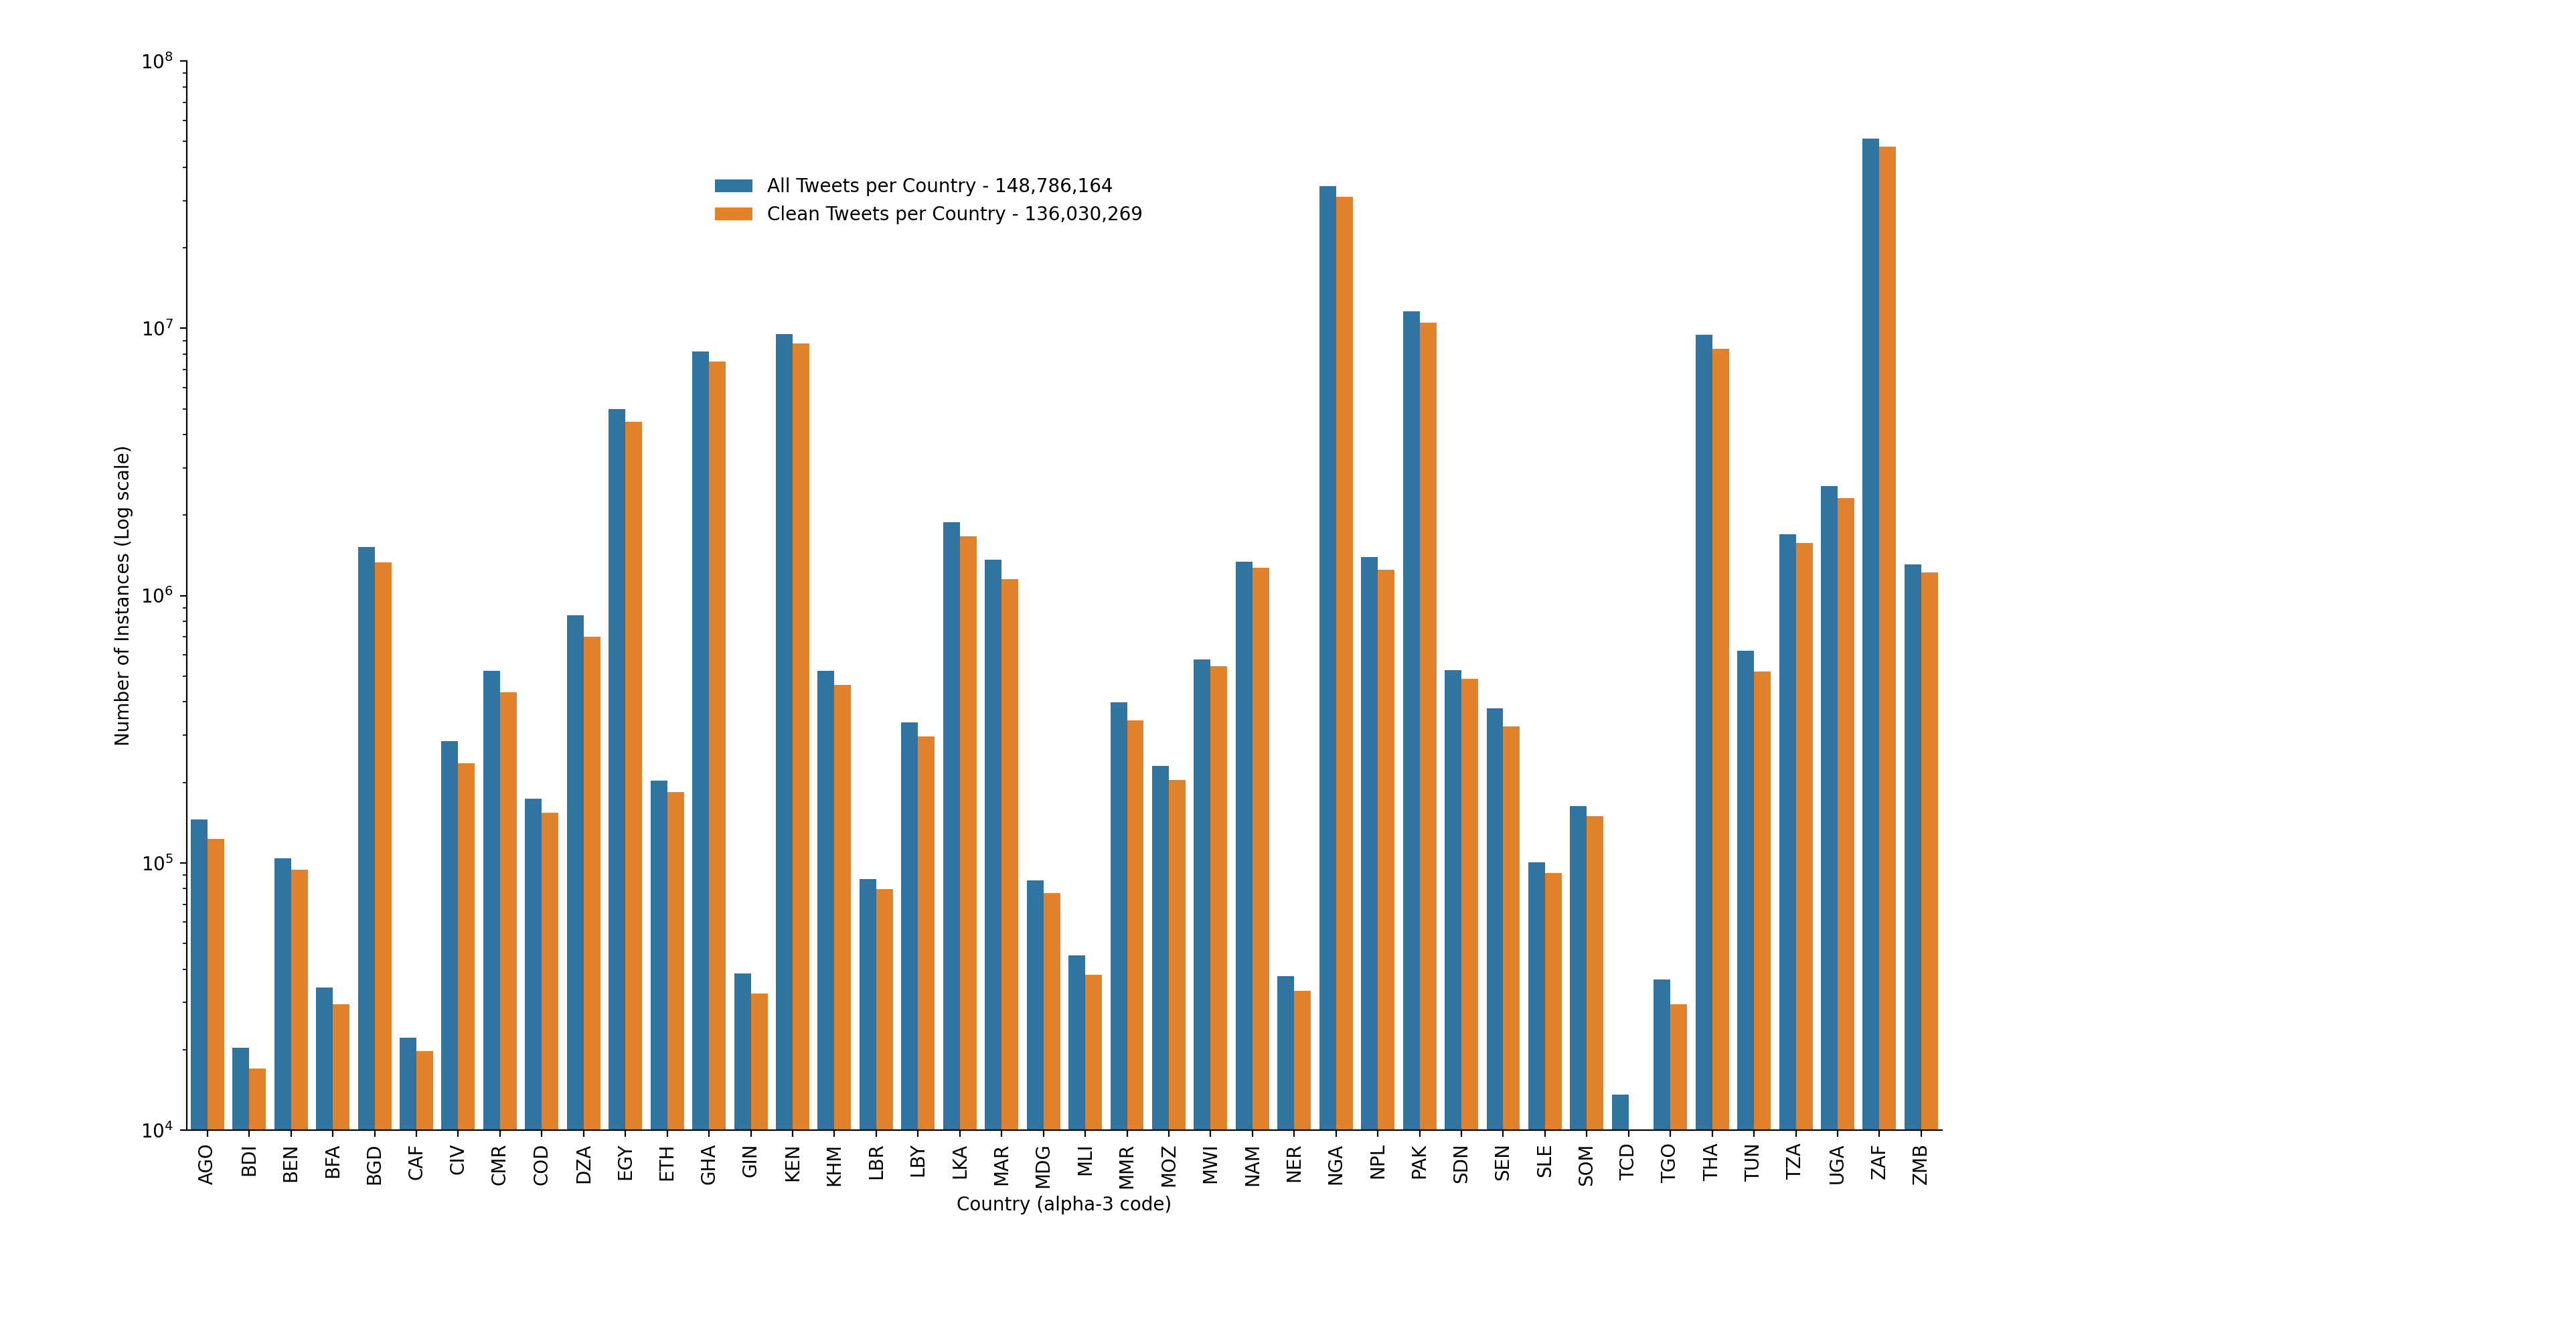

In [6]:
per_country_instance_stats = df.groupby("country").agg({
    "total_instances": sum,
    "total_eligible_instances": sum
}).reset_index()

# https://stackoverflow.com/questions/38807895/seaborn-multiple-barplots
# https://pandas.pydata.org/docs/reference/api/pandas.melt.html
d = pd.melt(
    per_country_instance_stats, 
    id_vars=["country"], 
    value_vars=["total_instances", "total_eligible_instances"],
    var_name="count_type", 
    value_name="count"
)

# Plot
# https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
g = sns.catplot(
    data=d, kind="bar", x="country", y="count", height=5, aspect=1.5, hue="count_type"
)

# Prettify
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html
g.set(yscale="log", ylim=(10**4, 10**8))
g.set_xticklabels(rotation=90)
g.set_axis_labels("Country (alpha-3 code)", "Number of Instances (Log scale)")
g.legend.set_title("")
g.legend.get_texts()[0].set_text(f"All Tweets per Country - {df.total_instances.sum():,}")
g.legend.get_texts()[1].set_text(f"Clean Tweets per Country - {df.total_eligible_instances.sum():,}")
g.legend.set_bbox_to_anchor((0.45, 0.85))
g.tight_layout()

## Q2: How many tweets per day?

Tweets per day as a CDF to determine a reasonable cutoff.

Check that countries are still represented.

Check percentiles. For each percentile, how many bags are there? How many instances? How many countries?

86,096 bags left of 86,270 after cleaning (99.80%).
42 countries


<IPython.core.display.Javascript object>


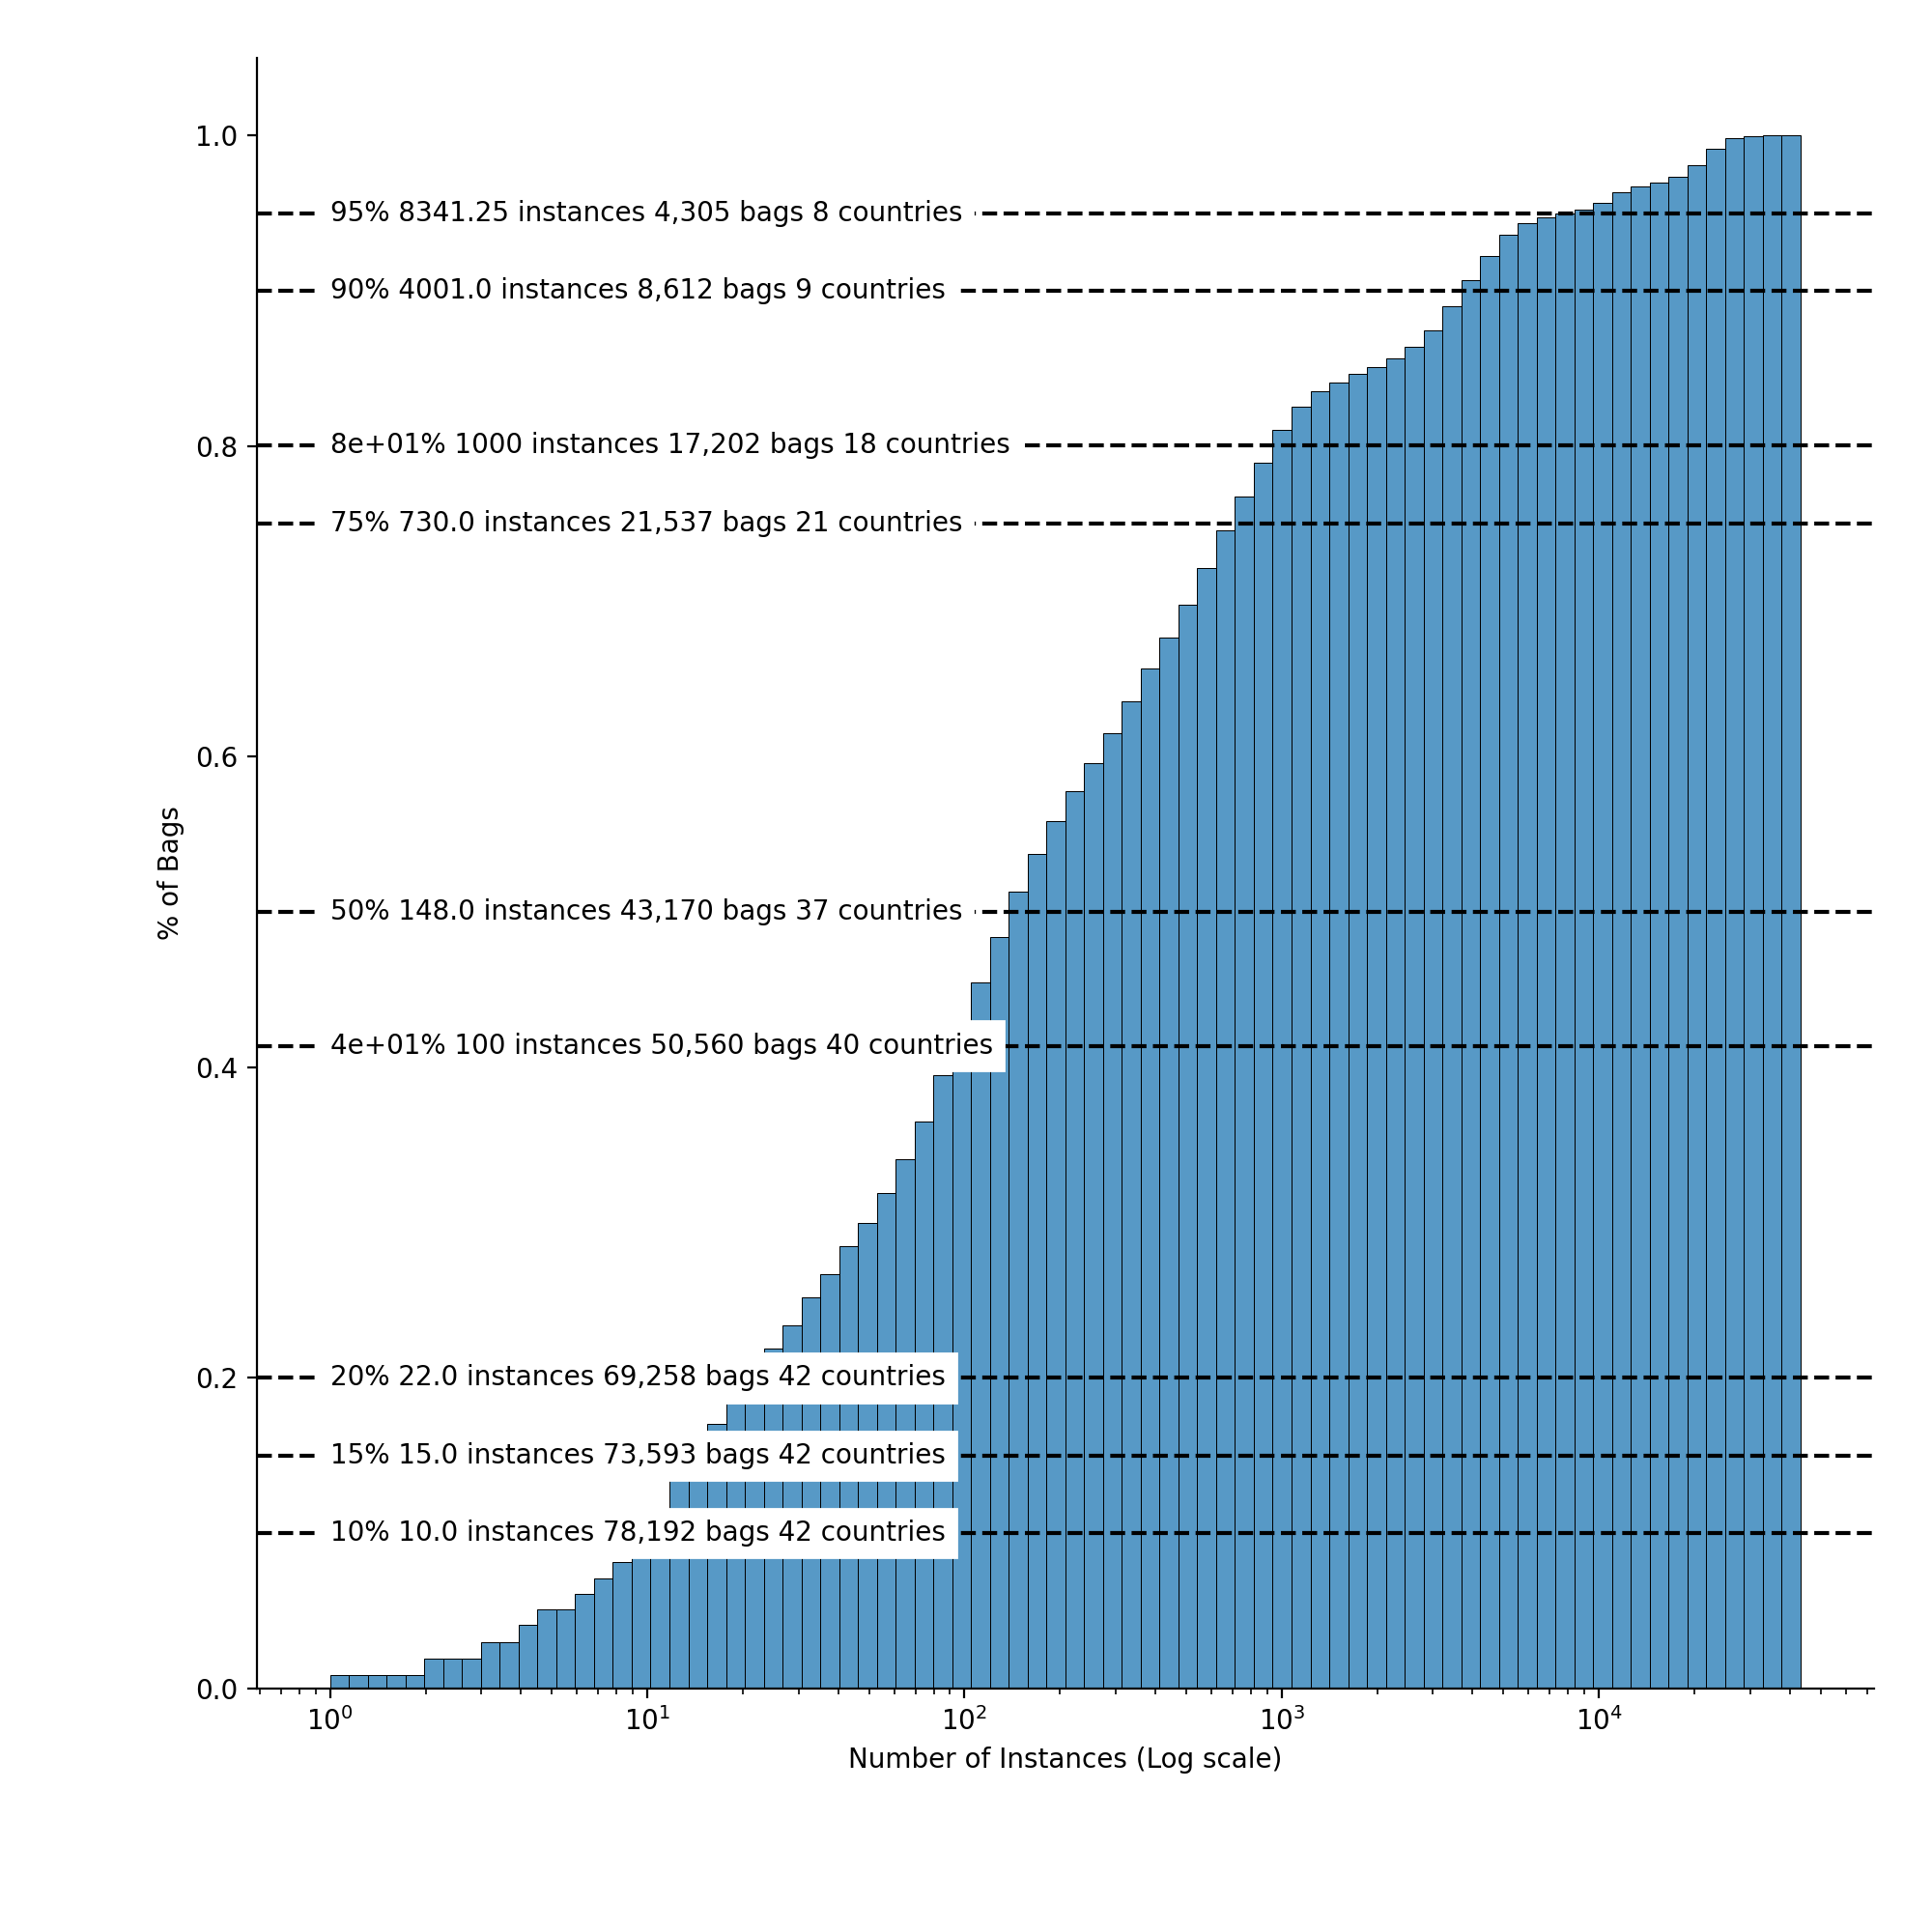

10%	10.0	78,192	42	set()
15%	15.0	73,593	42	set()
20%	22.0	69,258	42	set()
50%	148.0	43,170	37	{'TCD', 'BDI', 'CAF', 'MLI', 'TGO'}
75%	730.0	21,537	21	{'SOM', 'TCD', 'BDI', 'MLI', 'LBY', 'MDG', 'CMR', 'SLE', 'SEN', 'ETH', 'COD', 'BEN', 'LBR', 'CIV', 'AGO', 'TGO', 'NER', 'BFA', 'CAF', 'SDN', 'GIN'}
90%	4001.0	8,612	9	{'SOM', 'TCD', 'BDI', 'MWI', 'KHM', 'MLI', 'NPL', 'LBY', 'BGD', 'MMR', 'NAM', 'MDG', 'TUN', 'CMR', 'SLE', 'SEN', 'ETH', 'LKA', 'COD', 'ZMB', 'BEN', 'DZA', 'LBR', 'CIV', 'TZA', 'AGO', 'TGO', 'NER', 'BFA', 'CAF', 'MOZ', 'SDN', 'GIN'}
95%	8341.25	4,305	8	{'SOM', 'TCD', 'BDI', 'MWI', 'KHM', 'MLI', 'NPL', 'LBY', 'BGD', 'MMR', 'NAM', 'MDG', 'TUN', 'CMR', 'SLE', 'SEN', 'ETH', 'LKA', 'COD', 'ZMB', 'BEN', 'DZA', 'LBR', 'CIV', 'UGA', 'TZA', 'AGO', 'TGO', 'NER', 'BFA', 'CAF', 'MOZ', 'SDN', 'GIN'}
41.392747630551945%	100	50,560	40	{'BDI', 'CAF'}
80.02694666418881%	1000	17,202	18	{'SOM', 'TCD', 'BDI', 'MWI', 'KHM', 'MLI', 'LBY', 'MDG', 'CMR', 'SLE', 'SEN', 'ETH', 'COD', 'BEN', 'LBR', 'C

In [7]:
# https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.histplot
eligible_df = df[df.total_eligible_instances>0]
print(f"{len(eligible_df):,} bags left of {len(df):,} after cleaning ({len(eligible_df)/len(df):.2%}).")
print(f"{eligible_df.country.nunique():,} countries")
g2 = sns.displot(data=eligible_df, x="total_eligible_instances", log_scale=True, cumulative=True, stat="density")
g2.set_axis_labels("Number of Instances (Log scale)", "% of Bags")
ax = g2.axes[0][0]

# https://numpy.org/doc/stable/reference/generated/numpy.percentile.html
percentiles = [10, 15, 20, 50, 75, 90, 95]
all_countries = set(eligible_df.country.unique())
for p, value_at_p in zip(percentiles, np.percentile(eligible_df.total_eligible_instances, percentiles)):
    temp = eligible_df[eligible_df.total_eligible_instances>=value_at_p]
    temp_countries = set(temp.country.unique())
    n_country = temp.country.nunique()
    n_bags = len(temp)
    ax.axhline(p/100, linestyle="--", color="black")
    ax.text(1, p/100, f"{p}% {value_at_p} instances {n_bags:,} bags {n_country} countries", va='center', backgroundcolor='w')
    print(f"{p}%\t{value_at_p}\t{n_bags:,}\t{n_country}\t{all_countries.difference(temp_countries)}")

# How many bags have at least X tweets?
# Which countries are missing?
for value_at_p in [100, 1000]:
    p = stats.percentileofscore(eligible_df.total_eligible_instances, value_at_p)
    temp = eligible_df[eligible_df.total_eligible_instances>=value_at_p]
    temp_countries = set(temp.country.unique())
    n_country = temp.country.nunique()
    n_bags = len(temp)
    ax.axhline(p/100, linestyle="--", color="black")
    ax.text(1, p/100, f"{p:.0}% {value_at_p} instances {n_bags:,} bags {n_country} countries", va='center', backgroundcolor='w')
    print(f"{p}%\t{value_at_p}\t{n_bags:,}\t{n_country}\t{all_countries.difference(temp_countries)}")
